# Steepest descent (analysis of step size)

Given the following cost function to optimize:
$$J = \frac{1}{2} ||\mathbf{d} - \mathbf{G} \mathbf{m}||_2^2 $$

    
- Steepest descent:
    
    $$\mathbf{m}_{k+1} = \mathbf{m}_{k} + \alpha_{k+1} \frac{dJ}{d\mathbf{m}_{k}} $$
    
    where $\mathbf{r} = \mathbf{G}^T(\mathbf{d} - \mathbf{G}\mathbf{m})$, $\frac{dJ}{d\mathbf{m}} = \mathbf{r}$, $\alpha = \frac{\mathbf{r}^T \mathbf{r}}{\mathbf{r}^T  \mathbf{G}^H \mathbf{G} \mathbf{r}}$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from pylops import *
from stochmdd.steepest import *

plt.style.use('default')  # seaborn-whitegrid, ggplot, bmh

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 18

plt.rc('text', usetex=True)

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)     # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title
plt.rc('font', weight='bold')  # fontsize of the figure title

Let's start by setting up the forward problem. 

We also compute the condition number of the operator $\mathbf{G}$ - note: the further the conditioning number from 1 the further the behaviour of the two solvers we will use in the following

In [2]:
m = np.array([1, 1])
G = np.array([[1., 4.], 
              [1., 3.],
              [6., 2.],])
print('G^T G', G.T @ G)
Gop = MatrixMult(G)
d = Gop @ m
print('d', d)
print('G eigenvalues', np.linalg.eig(G.T @ G)[0])
print('G condition number %f' % np.linalg.cond(G.T @ G))

G^T G [[38. 19.]
 [19. 29.]]
d [5. 4. 8.]
G eigenvalues [53.02562419 13.97437581]
G condition number 3.794490


Let's define now the cost function to optimize:

$$ J = \frac{1}{2} \mathbf{m}^T \mathbf{G}^T\mathbf{G} \mathbf{m} - \mathbf{m}^T \mathbf{G}^T \mathbf{d} + \frac{1}{2} \mathbf{d}^T \mathbf{d} $$

In [3]:
# cost function grid
nm1, nm2 = 51, 51
m_min, m_max = (m[0] - 1.2, m[1] - 1.2), (m[0] + 1.2, m[1] + 1.2)
m1, m2 = np.mgrid[m_min[0]:m_max[0]:1j*nm1, m_min[1]:m_max[1]:1j*nm2]
mgrid = np.vstack((m1.ravel(), m2.ravel()))

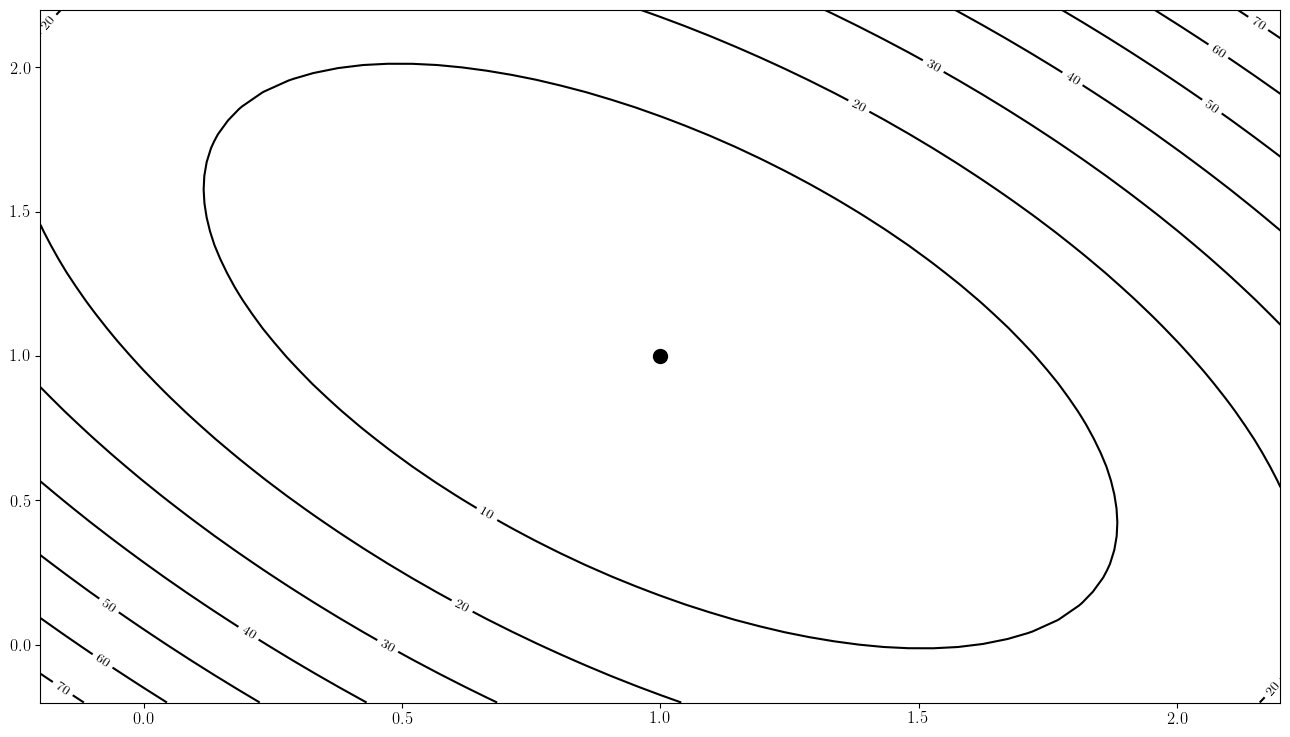

In [4]:
J = 0.5 * np.sum(mgrid * (G.T @ G @ mgrid), axis=0) - (mgrid.T @ G.T @ d[:, np.newaxis]).squeeze() + 0.5 *d.T @ d
J = J.reshape(nm1, nm2)

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
cs = ax.contour(m1, m2, J, colors='k')
ax.clabel(cs, inline=1, fontsize=10)
ax.plot(m[0], m[1], '.k', ms=20);

[1.00191701 1.00151602]
[1.55081238 1.43301849]
[1.00003103 0.99998449]


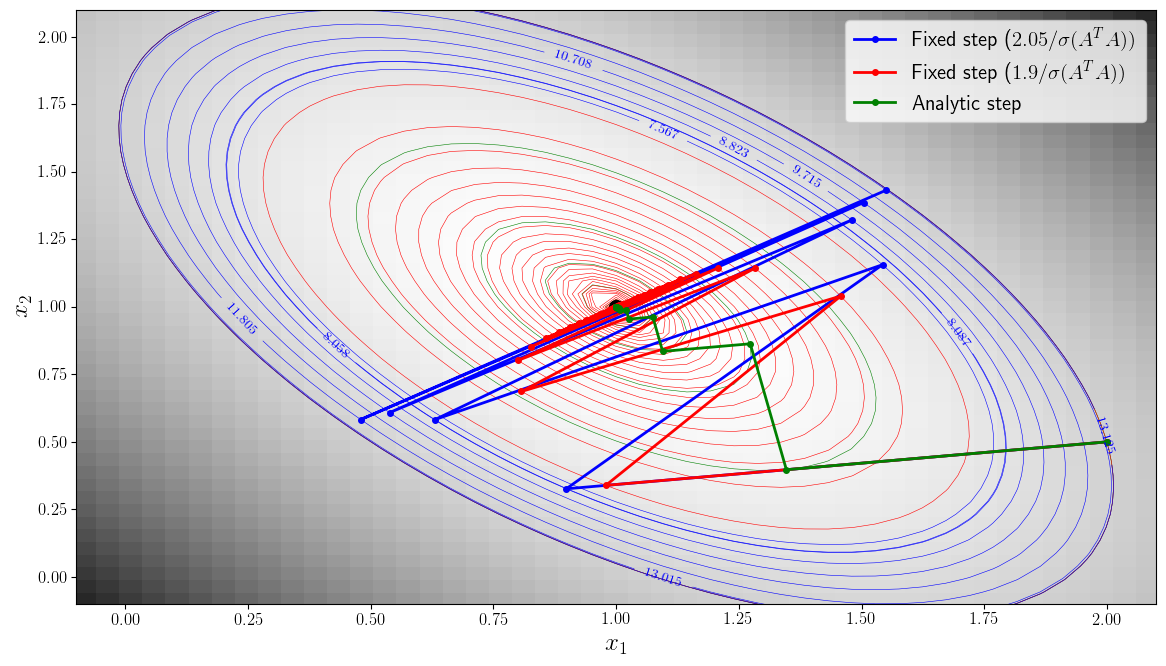

In [11]:
m0 = np.array([m[0]+1, m[1]-0.5])

# max allowed step-size (Landweber iteration)
alphamax = 1.9 / np.max(np.linalg.eig(G.T @ G)[0])
msd, rsd, alpha = steepest_descent(Gop.H @ Gop, Gop.H @ d, niter=50, m0=m0, a=alphamax, tol=1e-3)
msd = msd.T
print(msd[:, -1])


# beyond max allowed step-size (Landweber iteration)
alphamax = 2.05 / np.max(np.linalg.eig(G.T @ G)[0])
msd1, rsd1, alpha = steepest_descent(Gop.H @ Gop, Gop.H @ d, niter=8, m0=m0, a=alphamax, tol=1e-3)
msd1 = msd1.T
print(msd1[:, -1])

# analytical stepsize
msdana, rsdana, alphaana = steepest_descent(Gop.H @ Gop, Gop.H @ d, niter=50, m0=m0, a=None, tol=1e-3)
msdana = msdana.T
print(msdana[:, -1])

# cost function at solution
Jsd = 0.5 * np.sum(msd * (G.T @ G @ msd), axis=0) - (msd.T @ G.T @ d[:, np.newaxis]).squeeze() + 0.5 *d.T @ d
Jsd1 = 0.5 * np.sum(msd1 * (G.T @ G @ msd1), axis=0) - (msd1.T @ G.T @ d[:, np.newaxis]).squeeze() + 0.5 *d.T @ d
Jsdana = 0.5 * np.sum(msdana * (G.T @ G @ msdana), axis=0) - (msdana.T @ G.T @ d[:, np.newaxis]).squeeze() + 0.5 *d.T @ d
 
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
cs = ax.imshow(J.T, cmap='gray_r', origin='lower', extent=(m_min[0], m_max[0], m_min[1], m_max[1]))
cs = ax.contour(m1, m2, J, levels=np.sort(np.unique(Jsdana)), colors='g', linewidths=0.4)
cs = ax.contour(m1, m2, J, levels=np.sort(np.unique(Jsd)), colors='r', linewidths=0.4)
cs = ax.contour(m1, m2, J, levels=np.sort(np.unique(Jsd1)), colors='b', linewidths=0.4)
ax.clabel(cs, inline=1, fontsize=10)
ax.plot(m[0], m[1], '.k', ms=20);
ax.plot(msd1[0], msd1[1], '.-b', lw=2, ms=8, label=r'Fixed step ($2.05 / \sigma(A^T A))$')
ax.plot(msd[0], msd[1], '.-r', lw=2, ms=8, label=r'Fixed step ($1.9 / \sigma(A^T A))$')
ax.plot(msdana[0], msdana[1], '.-g', lw=2, ms=8, label='Analytic step')
ax.set_xlabel(r'$x_1$');
ax.set_ylabel(r'$x_2$');
ax.legend(prop={'size': 15})
ax.axis('tight');
ax.set_xlim(-0.1, 2.1);
ax.set_ylim(-0.1, 2.1);
plt.tight_layout()
plt.savefig('../../Figs/Paper/Steepest.eps', dpi=150)

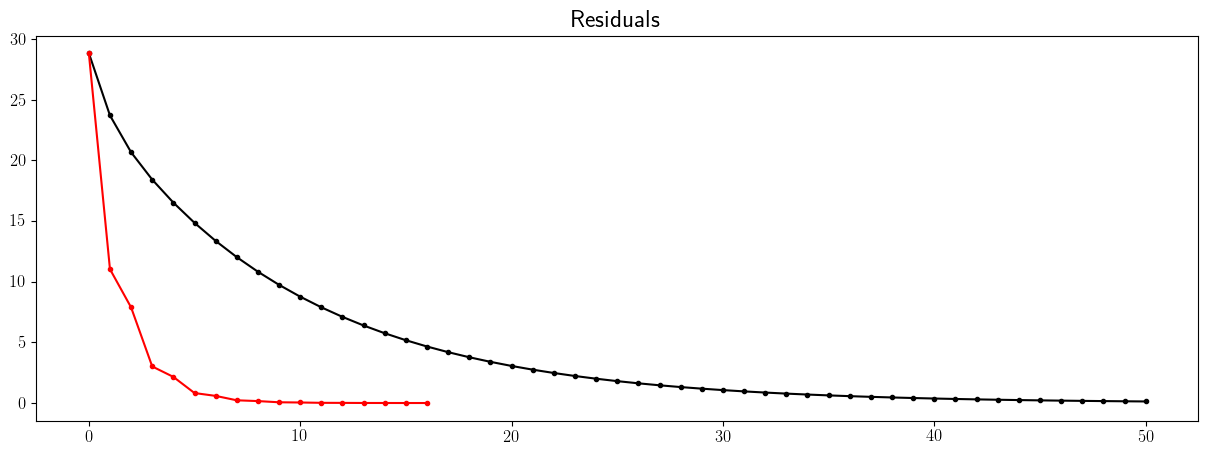

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(rsd, '.-k')
ax.plot(rsdana, '.-r')
ax.set_title('Residuals');

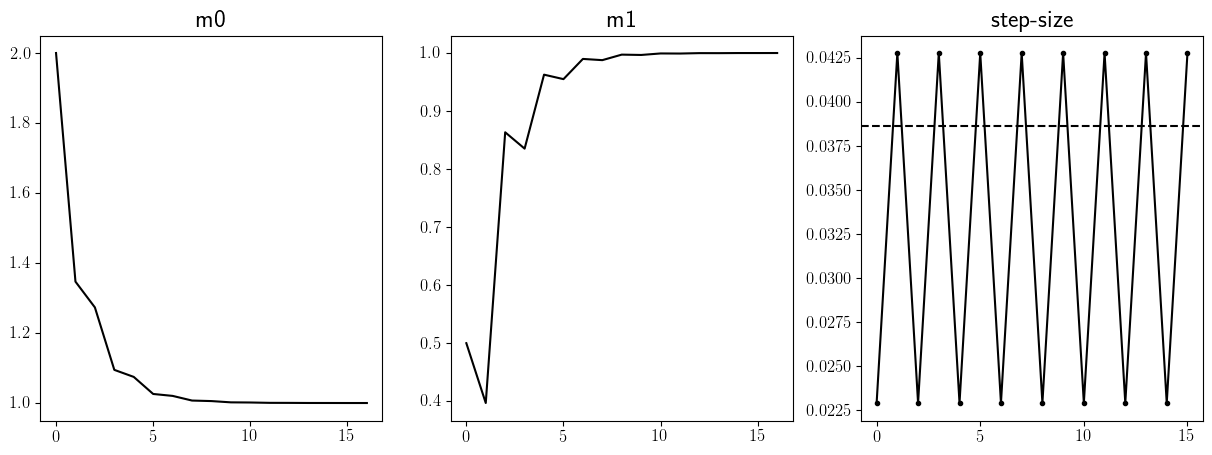

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(msdana[0], 'k')
axs[0].set_title('m0')
axs[1].plot(msdana[1], 'k')
axs[1].set_title('m1')
axs[2].axhline(alphamax, c='k', linestyle='--')
axs[2].plot(alphaana, '.-k')
axs[2].set_title('step-size');